# 以LSTM演算法預測股價

## 載入相關套件 

In [104]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchtext
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import torch.utils.data as Data

## 判斷GPU是否存在

In [105]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## 載入資料

In [106]:
#df = pd.read_csv('./nlp_data/AMZN_2006-01-01_to_2018-01-01.csv')
df = pd.read_csv('./nlp_data/btc_usdt_data.csv')
df.head()

,Date,open,high,low,Close,vol
0,2022-07-15 00:00:00+00:00,20591.3,20594.8,20579.7,20594.8,4.869115
1,2022-07-15 00:01:00+00:00,20594.5,20603.1,20590.5,20593.1,18.127575
2,2022-07-15 00:02:00+00:00,20595.4,20602.3,20579.5,20579.5,1.192547
3,2022-07-15 00:03:00+00:00,20575.3,20596.1,20550.7,20585.7,7.451167
4,2022-07-15 00:04:00+00:00,20585.8,20594.9,20581.5,20587.7,1.090570


In [107]:
df.tail()

,Date,open,high,low,Close,vol
98463,2022-09-21 09:03:00+00:00,18866.3,18866.9,18861.4,18861.4,0.893010
98464,2022-09-21 09:04:00+00:00,18861.5,18862.4,18861.5,18862.4,0.012011
98465,2022-09-21 09:05:00+00:00,18862.3,18865.0,18861.4,18865.0,0.932398
98466,2022-09-21 09:06:00+00:00,18865.4,18868.5,18865.4,18868.0,5.747388
98467,2022-09-21 09:07:00+00:00,18868.0,18868.0,18868.0,18868.0,0.000000


## 繪圖

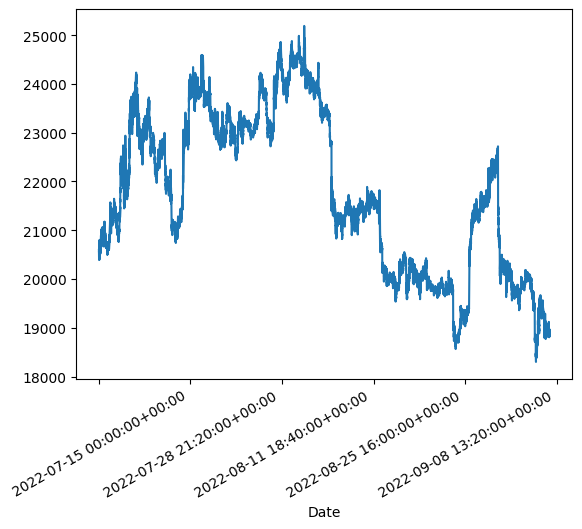

In [108]:
df2 = df.set_index('Date')
df2.Close.plot(legend=None)
plt.xticks(rotation=30);


## 實驗一 : 直接透過給定的前幾天預測下一天

In [109]:
from sklearn.preprocessing import MinMaxScaler
look_back = 10 # 以前N期資料為 X，當期資料為 Y
forward_days = 3
# 函數：以前N期資料為 X，當前期資料為 Y
def create_dataset(data1, look_back,forward_days=1):
    print(data1.shape)
    x, y = [], []
    for i in range(len(data1)-look_back-forward_days):
        _x = data1[i:(i+look_back)]
        _y = data1[(i+look_back):(i+look_back+forward_days),3:4]
        x.append(_x)
        y.append(_y)
    x = torch.Tensor(np.array(x))
    y = torch.Tensor(np.array(y).reshape(-1,forward_days))  
    return (x, y)

dataset = df2.values.astype('float32')
# X 常態化
scaler = MinMaxScaler()
dataset = scaler.fit_transform(dataset)
# 資料分割
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train_data, test_data = dataset[0:train_size,:], dataset[train_size-look_back:len(dataset),:]

trainX, trainY = create_dataset(train_data, look_back,forward_days)
testX, testY = create_dataset(test_data, look_back,forward_days)
dataset.shape, trainY.shape

(65973, 5)
(32505, 5)


((98468, 5), torch.Size([65960, 3]))

In [110]:
trainX.shape, trainY.shape, testX.shape, testY.shape

(torch.Size([65960, 10, 5]),
 torch.Size([65960, 3]),
 torch.Size([32492, 10, 5]),
 torch.Size([32492, 3]))

In [111]:
batch_size=100
# Dataset
train_dataset = Data.TensorDataset(trainX, trainY)#.to(device)
test_dataset = Data.TensorDataset(testX, testY)#.to(device)
# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
         batch_size=batch_size,
         shuffle=False,
         pin_memory=True,
         num_workers=4
         )
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
         batch_size=batch_size,
         shuffle=False,
         pin_memory=True,
         num_workers=4
         )

In [112]:
#torch.cat((trainX.reshape(trainX.shape[0], trainX.shape[1]), trainY), axis=1)

In [113]:
train_dataset[0:1]

(tensor([[[3.3273e-01, 3.2222e-01, 3.3842e-01, 3.3313e-01, 1.8467e-03],
          [3.3319e-01, 3.2344e-01, 3.3998e-01, 3.3288e-01, 6.8752e-03],
          [3.3332e-01, 3.2332e-01, 3.3840e-01, 3.3091e-01, 4.5229e-04],
          [3.3041e-01, 3.2241e-01, 3.3424e-01, 3.3181e-01, 2.8260e-03],
          [3.3193e-01, 3.2223e-01, 3.3868e-01, 3.3210e-01, 4.1362e-04],
          [3.3221e-01, 3.2241e-01, 3.3958e-01, 3.3283e-01, 3.2588e-04],
          [3.3242e-01, 3.2184e-01, 3.3847e-01, 3.3222e-01, 6.2726e-04],
          [3.3209e-01, 3.2116e-01, 3.3467e-01, 3.2716e-01, 6.4819e-04],
          [3.2727e-01, 3.1704e-01, 3.3282e-01, 3.2802e-01, 2.2215e-03],
          [3.2813e-01, 3.1706e-01, 3.3417e-01, 3.2757e-01, 1.2620e-03]]]),
 tensor([[0.3218, 0.3237, 0.3260]]))

## 建立模型

In [114]:
hidden_size = 15
num_layers = 1
feature_number = testX.shape[2]
class TimeSeriesModel(nn.Module):
    def __init__(self, look_back, hidden_size=10, num_layers=1,forward_days=1):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.LSTM(feature_number, self.hidden_size, num_layers=self.num_layers
                           , batch_first=True)
        self.fc = nn.Linear(self.hidden_size, forward_days)
        self.init_weights()

    def init_weights(self):
        initrange = 0.5
        self.fc.weight.data.uniform_(-initrange, initrange)
        self.fc.bias.data.zero_()

    def forward(self, x):
        #print(x.shape)
        # rnn_out, h_out = self.rnn(x)
        h_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size,device=x.device)        
        c_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size,device=x.device)
        out, (h_out, _) = self.rnn(x, (h_0, c_0))
        #print(h_out.shape)
        
        # 取最後一層的 h，並轉成二維
#         h_out = h_out[-1].view(-1, self.hidden_size)  
#         return self.fc(h_out)
        # 取最後一個輸出，並轉成二維
        flatten_output = out[:, -1].view(-1, self.hidden_size)  
        return self.fc(flatten_output)

model = TimeSeriesModel(look_back, hidden_size=hidden_size, num_layers=num_layers,forward_days=forward_days).to(device)

In [115]:
model

TimeSeriesModel(
  (rnn): LSTM(5, 15, batch_first=True)
  (fc): Linear(in_features=15, out_features=3, bias=True)
)

## 模型訓練

In [116]:
trainY.shape

torch.Size([65960, 3])

In [117]:
'''
num_epochs = 20000
learning_rate = 0.01

def train(train_loader):
    criterion = torch.nn.MSELoss()  # MSE
    #criterion = torch.nn.MAELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    model.train()
    for epoch in range(num_epochs):
        print("Epoch :",epoch)
        for i, (data, label) in enumerate(train_loader):
          #data ,label = data.to(device), label.to(device) 
          #optimizer.zero_grad()
          #outputs = model(data)
          #if epoch <= 0: print(outputs.shape)
          #loss = criterion(outputs, label)    
          #loss.backward()
          #optimizer.step()
          if 2*i % (batch_size) == 0:
              #print(f"Epoch: {epoch},# loss: {loss.item():.10f}")
              print(f"Epoch: {epoch}")

train(train_loader)
'''

'\nnum_epochs = 20000\nlearning_rate = 0.01\n\ndef train(train_loader):\n    criterion = torch.nn.MSELoss()  # MSE\n    #criterion = torch.nn.MAELoss()\n    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)\n    model.train()\n    for epoch in range(num_epochs):\n        print("Epoch :",epoch)\n        for i, (data, label) in enumerate(train_loader):\n          #data ,label = data.to(device), label.to(device) \n          #optimizer.zero_grad()\n          #outputs = model(data)\n          #if epoch <= 0: print(outputs.shape)\n          #loss = criterion(outputs, label)    \n          #loss.backward()\n          #optimizer.step()\n          if 2*i % (batch_size) == 0:\n              #print(f"Epoch: {epoch},# loss: {loss.item():.10f}")\n              print(f"Epoch: {epoch}")\n\ntrain(train_loader)\n'

In [118]:
num_epochs = 500000
learning_rate = 0.001

def train(trainX, trainY):
    #criterion = torch.nn.MSELoss()  # MSE
    criterion = torch.nn.MSELoss().to(device)  
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=10**(-10))
    model.train()
    trainX ,trainY = trainX.to(device), trainY.to(device)  
    for epoch in range(num_epochs):  
           
        optimizer.zero_grad()
        outputs = model(trainX)
        if epoch <= 0: print(outputs.shape)
        loss = criterion(outputs, trainY)    
        loss.backward()
        optimizer.step()
        if epoch % 100 == 0:
            print(f"Epoch: {epoch}, loss: {loss.item():.10f}")

train(trainX, trainY)


torch.Size([65960, 3])
Epoch: 0, loss: 0.3151719570
Epoch: 100, loss: 0.0037896356
Epoch: 200, loss: 0.0003276602
Epoch: 300, loss: 0.0001033227
Epoch: 400, loss: 0.0000741953
Epoch: 500, loss: 0.0000667774
Epoch: 600, loss: 0.0000619056
Epoch: 700, loss: 0.0000584551
Epoch: 800, loss: 0.0000559458
Epoch: 900, loss: 0.0000539583
Epoch: 1000, loss: 0.0000522255
Epoch: 1100, loss: 0.0000506158
Epoch: 1200, loss: 0.0000490780
Epoch: 1300, loss: 0.0000475980
Epoch: 1400, loss: 0.0000461754
Epoch: 1500, loss: 0.0000448139
Epoch: 1600, loss: 0.0000435169
Epoch: 1700, loss: 0.0000422870
Epoch: 1800, loss: 0.0000411253
Epoch: 1900, loss: 0.0000400313
Epoch: 2000, loss: 0.0000390035
Epoch: 2100, loss: 0.0000380393
Epoch: 2200, loss: 0.0000371351
Epoch: 2300, loss: 0.0000362870
Epoch: 2400, loss: 0.0000354908
Epoch: 2500, loss: 0.0000347422
Epoch: 2600, loss: 0.0000340368
Epoch: 2700, loss: 0.0000333706
Epoch: 2800, loss: 0.0000327400
Epoch: 2900, loss: 0.0000321418
Epoch: 3000, loss: 0.00003157

## 模型評估

In [119]:
model.eval()
trainPredict = model(trainX.to(device)).cpu().detach().numpy()
testPredict = model(testX.to(device)).cpu().detach().numpy()
trainPredict.shape

(65960, 3)

In [120]:
trainY.shape, trainPredict.shape

(torch.Size([65960, 3]), (65960, 3))

In [121]:
trainY[0:10,:], trainPredict[0:10,:]

(tensor([[0.3218, 0.3237, 0.3260],
         [0.3237, 0.3260, 0.3232],
         [0.3260, 0.3232, 0.3211],
         [0.3232, 0.3211, 0.3212],
         [0.3211, 0.3212, 0.3200],
         [0.3212, 0.3200, 0.3174],
         [0.3200, 0.3174, 0.3168],
         [0.3174, 0.3168, 0.3185],
         [0.3168, 0.3185, 0.3180],
         [0.3185, 0.3180, 0.3189]]),
 array([[0.32756788, 0.3275783 , 0.3276347 ],
        [0.32219738, 0.3222346 , 0.32232955],
        [0.32386503, 0.32390404, 0.3239915 ],
        [0.32597578, 0.32601258, 0.32607526],
        [0.32328895, 0.32329088, 0.32332057],
        [0.3212149 , 0.3211806 , 0.32117587],
        [0.32116327, 0.32109654, 0.3210492 ],
        [0.3198702 , 0.31981167, 0.31978017],
        [0.31736308, 0.31731445, 0.31730133],
        [0.31689838, 0.31682995, 0.31677654]], dtype=float32))

In [122]:
from sklearn.metrics import mean_squared_error
import math 

# 還原常態化的訓練及測試資料
print(trainPredict.shape)
trainPredict1 = scaler.inverse_transform(np.tile(trainPredict[:,0:1],(1,5)))[:,0]
print(trainY.shape)
trainY_actual1 = scaler.inverse_transform(np.tile(trainY[:,0:1],(1,5)))[:,0]
print(testPredict.shape)
testPredict1 = scaler.inverse_transform(np.tile(testPredict[:,0:1],(1,5)))[:,0]
testY_actual1 = scaler.inverse_transform(np.tile(testY[:,0:1],(1,5)))[:,0]

# 計算 RMSE
print(trainPredict1.shape)
print(trainY_actual1.shape)
trainScore = math.sqrt(mean_squared_error(trainY_actual1, trainPredict1))
print(f'Train RMSE: {trainScore:.2f}')
testScore = math.sqrt(mean_squared_error(testY_actual1, testPredict1))
print(f'Test RMSE:  {testScore:.2f}')

(65960, 3)
torch.Size([65960, 3])
(32492, 3)
(65960,)
(65960,)
Train RMSE: 18.50
Test RMSE:  25.27


## 繪製實際資料和預測資料的圖表

In [123]:
dataset.shape

(98468, 5)

In [124]:
trainPredict1.shape

(65960,)

(98468, 1)
(98468, 1)
(98468, 1)


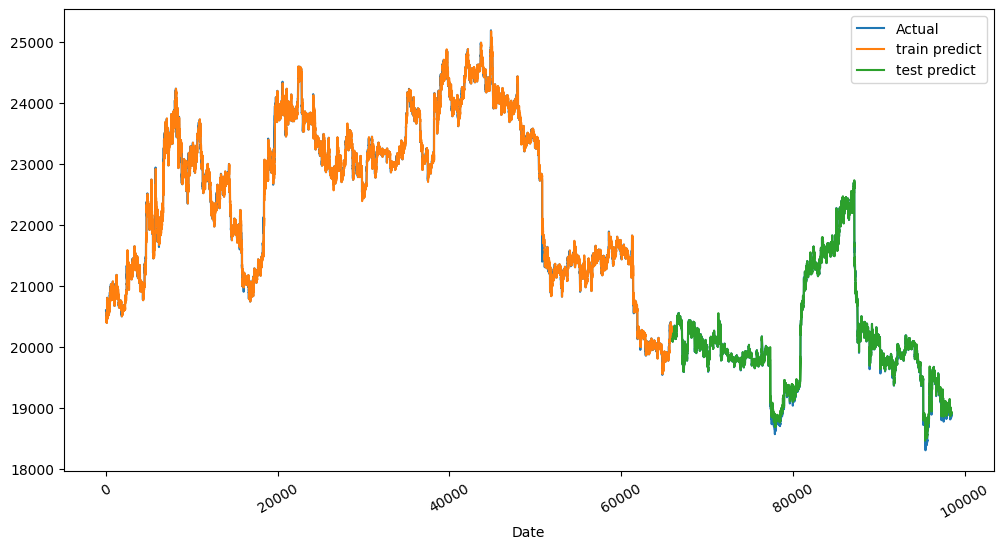

In [154]:
# 訓練資料的 X/Y
trainPredictPlot = np.empty_like(dataset[:,3:4])
trainPredictPlot[:, :] = np.nan
print(trainPredictPlot.shape)
trainPredictPlot[look_back:len(trainPredict1)+look_back, :] = trainPredict1.reshape((-1,1))
#trainPredictPlot[:look_back] = 0
print(trainPredictPlot.shape)
# 測試資料 X/Y
testPredictPlot = np.empty_like(dataset[:,3:4])
testPredictPlot[:, :] = np.nan
testPredictPlot[-testPredict1.shape[0]-1:-1, :] = testPredict1.reshape((-1,1))
actual = scaler.inverse_transform(dataset)[:,3:4]
print(testPredictPlot.shape)
# 繪圖
plt.figure(figsize=(12,6))
plt.plot(actual, label='Actual')
plt.plot(trainPredictPlot, label='train predict')
plt.plot(testPredictPlot, label='test predict')
plt.xticks(rotation=30)
plt.xlabel("Date")
plt.legend()
plt.show()


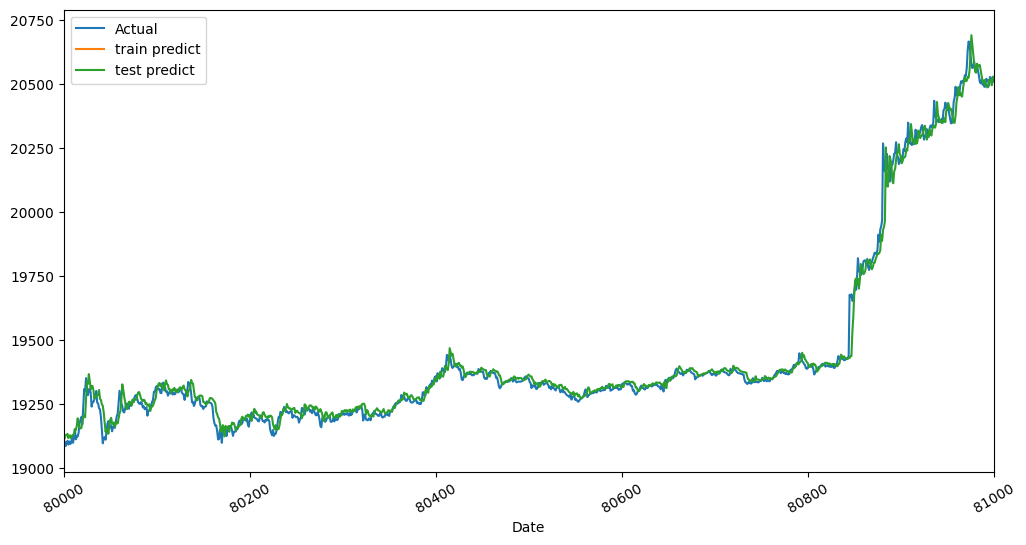

In [182]:
min_x = 80000
dist = 1000

plt.figure(figsize=(12,6))
plt.plot(actual, label='Actual')
plt.plot(trainPredictPlot, label='train predict')
plt.plot(testPredictPlot, label='test predict')
plt.xticks(rotation=30)
plt.xlim(xmin=min_x,xmax=min_x+dist)

if(min_x + dist < train_size):
    Ynum = np.hstack([trainPredictPlot[min_x:min_x+dist],actual[min_x:min_x+dist]])
elif(min_x > train_size):
    Ynum = np.hstack([testPredictPlot[min_x:min_x+dist],actual[min_x:min_x+dist]]) 
else:
    Ynum = np.hstack([trainPredictPlot[min_x:min_x+dist],testPredictPlot[min_x:min_x+dist],actual[min_x:min_x+dist]])

Ymin = np.nanmin(Ynum)
Ymax = np.nanmax(Ynum)
plt.ylim(ymin=Ymin-100,ymax=Ymax+100)

plt.xlabel("Date")
plt.legend()
plt.show()

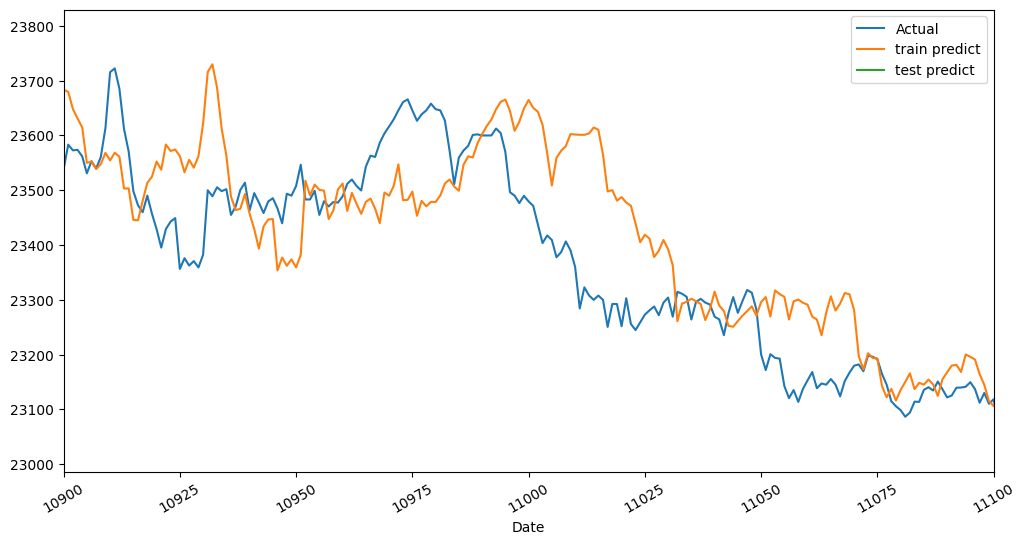

In [183]:
min_x = 10900
dist = 200

plt.figure(figsize=(12,6))
plt.plot(actual, label='Actual')
plt.plot(trainPredictPlot, label='train predict')
plt.plot(testPredictPlot, label='test predict')
plt.xticks(rotation=30)
plt.xlim(xmin=min_x,xmax=min_x+dist)

if(min_x + dist < train_size):
    Ynum = np.hstack([trainPredictPlot[min_x:min_x+dist],actual[min_x:min_x+dist]])
elif(min_x > train_size):
    Ynum = np.hstack([testPredictPlot[min_x:min_x+dist],actual[min_x:min_x+dist]]) 
else:
    Ynum = np.hstack([trainPredictPlot[min_x:min_x+dist],testPredictPlot[min_x:min_x+dist],actual[min_x:min_x+dist]])

Ymin = np.nanmin(Ynum)
Ymax = np.nanmax(Ynum)
plt.ylim(ymin=Ymin-100,ymax=Ymax+100)

plt.xlabel("Date")
plt.legend()
plt.show()

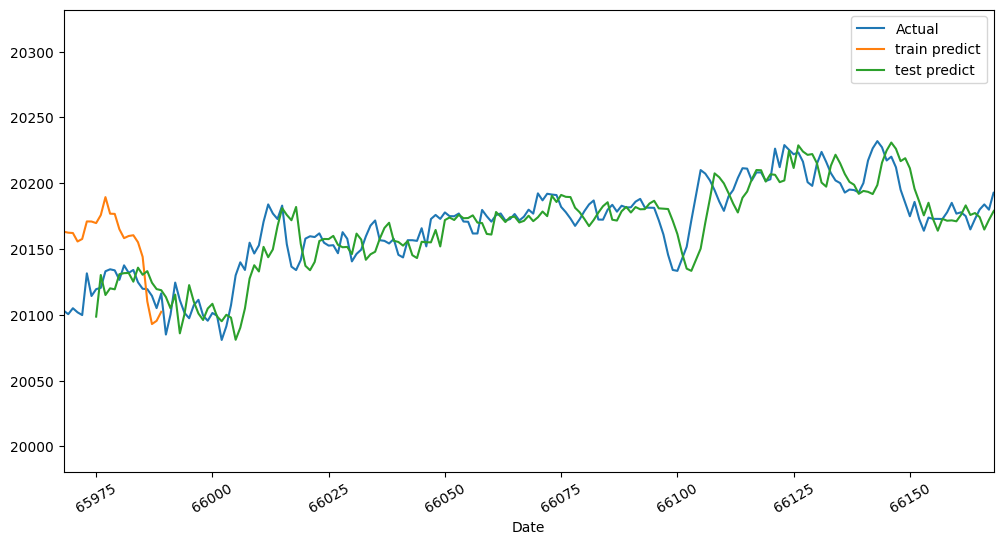

In [179]:
# 繪圖
min_x = train_size -5
dist = 200

plt.figure(figsize=(12,6))
plt.plot(actual, label='Actual')
plt.plot(trainPredictPlot, label='train predict')
plt.plot(testPredictPlot, label='test predict')
plt.xticks(rotation=30)
plt.xlim(xmin=min_x,xmax=min_x+dist)

if(min_x + dist < train_size):
    Ynum = np.hstack([trainPredictPlot[min_x:min_x+dist],actual[min_x:min_x+dist]])
elif(min_x > train_size):
    Ynum = np.hstack([testPredictPlot[min_x:min_x+dist],actual[min_x:min_x+dist]]) 
else:
    Ynum = np.hstack([trainPredictPlot[min_x:min_x+dist],testPredictPlot[min_x:min_x+dist],actual[min_x:min_x+dist]])

Ymin = np.nanmin(Ynum)
Ymax = np.nanmax(Ynum)
plt.ylim(ymin=Ymin-100,ymax=Ymax+100)

plt.xlabel("Date")
plt.legend()
plt.show()